# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un luar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro. Para ello se nos facilita un archivo  [csv](https://drive.google.com/open?id=1gTcb3WZ27DU0nMdvoyPBMYRFK8LU8-rt) donde aparecen el número de bicicletas contratadas todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de capturar la relación entre características y número de bicicletas contratadas en un modelo.


# 0. Carga de Datos

Cargaremos los datos de la misma forma que lo hemos hecho otras veces en Google Collaboratory.


In [1]:
# 0. load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bikes.csv to bikes.csv
User uploaded file "bikes.csv" with length 54187 bytes


Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *bikes*

In [2]:
# 0. load data in DataFrame
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),
                    index_col = 'date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


Vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [4]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2012-06-30']
test  = df.loc['2012-07-01':]

display_side_by_side(train.tail(),test.head())

,temperature,humidity,windspeed,count
date,,,,
2012-06-26,24.296565,42.145226,28.500501,1077.0
2012-06-27,27.607979,41.400771,23.088815,1077.0
2012-06-28,30.174329,44.890488,15.946777,921.0
2012-06-29,34.396361,48.589589,15.502169,829.0
2012-06-30,33.527119,47.814090,16.211915,854.0
,temperature,humidity,windspeed,count
date,,,,
2012-07-01,32.657877,47.038591,16.921660,879.0
2012-07-02,31.788635,46.263092,17.631406,904.0


In [5]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)
train.head()

,temperature,humidity,windspeed,count
0,2.716070,45.715346,21.414957,120.0
1,2.896673,54.267219,15.136882,108.0
2,4.235654,45.697702,17.034578,82.0
3,3.112643,50.237349,10.091568,88.0
4,2.723918,49.144928,15.738204,148.0


#1. Parametrización

Todo modelos de aprendizaje automático necesitan de cierta parametrización con el fin de que su comportamiento se ajuste mejor a cada problema concreto.
Según la naturaleza del modelo este puede tener muchos parámetros y encontrar la mejor combinación de los mismos puede ser tratado como un problema de búsqueda/optimización.

Este problema es denominado habitualmente **optimización de hiperparámetros**, donde los parámetros del algoritmo se denominan hiperparámetros, mientras que los coeficientes encontrados por el propio algoritmo de aprendizaje se denominan *parámetros*.

El planteamiento será del de buscar aquella parametrización que ofrezca los resultados de mayor calidad (con respecto a las métricas establecidas) y de mayor robustez.

Scikit-learn proporciona diferentes herramientas para que la optimización de estos hiperparámetros pueda ser lo más sencilla posible. En concreto ofrece dos alternativas, la *búsqueda aleatoria* (**RandomizedSearch**) y la *búsqueda en cuadrícula* (**GridSearch**)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

Para utilizar estas herramientas de búsqueda, primero necesitamos crear el conjunto de parámetros a muestrear durante el proceso de optimización.

Y crear (construir) el elemento que va a ser nuestro regresor


In [7]:
regressor = RandomForestRegressor(random_state=0)
regressor

RandomForestRegressor(random_state=0)

## RandomizedSearch

Para utilizar RandomizedSearchCV, primero necesitamos crear el conjunto de parámetros a muestrear durante el proceso de optimización.



In [8]:
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_features": [1.0, 'sqrt'], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [16, 12,8,4, 2,None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["squared_error", "absolute_error"]}

En cada iteración, el algoritmo elegirá una combinación diferente de las características. Si se probaran de forma exhaustiva todas las características el problema se volvería muy costoso computacionalmente. Al menos al utilizar búsqueda aleatoria se seleccionará al azar una muestra de las mismas para buscar en un reducido pero significativo rango de valores.


Los argumentos más importantes en RandomizedSearchCV son *n_iter*, que controla el número de combinaciones diferentes a probar, y *cv*, que es el número de *cruces* a usar para la validación cruzada. Más iteraciones cubrirán un espacio de búsqueda más amplio y más *cruces* de cv reducen las posibilidades de sobreaprendizaje, pero al aumentar cada una de ellas se incrementará el tiempo de ejecución.

Vamos a ejecutarla utilizando la validación cruzada (5-fold) y posteriormente busca entre 100 combinaciones diferentes de entre las especificadas

In [9]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist,
                               n_iter = 100, cv = 5, random_state=0, n_jobs = -1)

# Fit the random search model
rnd_regres.fit(X = train.drop(['count'], axis=1), y = train['count'])

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 8, 4, 2, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e53d90be290>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e53d90bc880>,
                                        'n_estimators': [4, 8, 16, 32, 64,
                                                         128]},
                   random_state=0)

In [10]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [11]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.051 (std: 0.610)
Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 22, 'n_estimators': 128}

Model with rank: 2
Mean validation score: -0.069 (std: 0.525)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 12, 'min_samples_split': 30, 'n_estimators': 16}

Model with rank: 3
Mean validation score: -0.078 (std: 0.514)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 8, 'max_features': 1.0, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 64}

Model with rank: 4
Mean validation score: -0.084 (std: 0.526)
Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 12, 'min_samples_split': 42, 'n_estimators': 64}

Model with rank: 5
Mean validation score: -0.086 (std: 0.464)
Param

In [12]:
rnd_regres.best_params_

{'bootstrap': False,
 'criterion': 'absolute_error',
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 22,
 'n_estimators': 128}

Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [13]:
# choose the best

best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = best_random.predict(X = test.drop(['count'], axis = 1,))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

MAE 263.4330930848053


Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

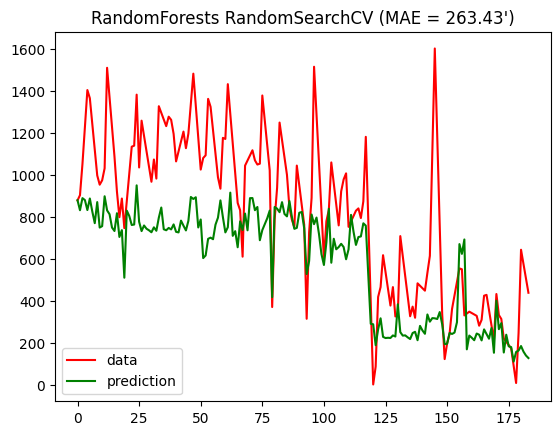

In [15]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.stack([i for i in range(test['count'].shape[0])])
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [16]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Random Forests': best_random.feature_importances_})

Feature Relevancies


,Attributes,Random Forests
0,temperature,0.754329
1,humidity,0.147587
2,windspeed,0.098083


## GridSearch

La búsqueda en cuadrícula es un enfoque de ajuste de parámetros que permite construir y evaluar metódicamente un modelo para cada combinación de parámetros de algoritmo especificados en una cuadrícula.

In [17]:
param_dist = {"n_estimators": [100, 128, 200, 256], # Number of trees in random forest
              "max_features": ['sqrt'], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [10, 12, 14], # Maximum number of levels in tree
              "min_samples_split": [10, 22, 30], #  Minimum number of samples required to split a node
              "min_samples_leaf": [1, 3, 10], # Minimum number of samples required at each leaf node
              "bootstrap": [False] # Method of selecting samples for training each tree
            }

In [18]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=5)

# Fit the random search model
grid_regres.fit(X = train.drop(['count'], axis=1), y = train['count'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'bootstrap': [False], 'max_depth': [10, 12, 14],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [10, 22, 30],
                         'n_estimators': [100, 128, 200, 256]})

In [19]:
report(grid_regres.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: -0.214 (std: 0.529)
Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 22, 'n_estimators': 256}

Model with rank: 2
Mean validation score: -0.214 (std: 0.516)
Parameters: {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 256}

Model with rank: 3
Mean validation score: -0.214 (std: 0.516)
Parameters: {'bootstrap': False, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 256}

Model with rank: 4
Mean validation score: -0.216 (std: 0.529)
Parameters: {'bootstrap': False, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 22, 'n_estimators': 256}

Model with rank: 5
Mean validation score: -0.217 (std: 0.518)
Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples

In [20]:
grid_regres.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=10, min_samples_split=22,
                      n_estimators=256, random_state=0)

In [21]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = best_grid.predict(X = test.drop(['count'], axis = 1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

MAE 244.46072371050283


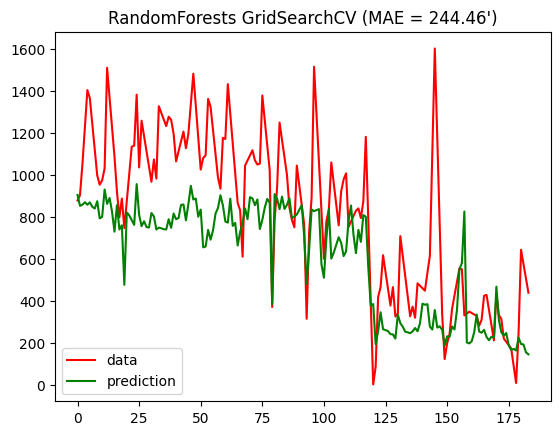

In [23]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.stack([i for i in range(test['count'].shape[0])])
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests GridSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [24]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Decision Tree': best_grid.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,temperature,0.805412
1,humidity,0.140545
2,windspeed,0.054044


## Boosting

Vamos a utilizar las mismas técnicas para optimizar los párametros de los algortimos basados en Boosting.

En primer lugar Adaboost, con parámetros como el número de árboles, el coeficiente de aprendizaje y la función de pérdida.


In [25]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

param_dist = {
 "n_estimators": [8, 32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1],
 "loss" : ['linear', 'square', 'exponential']
 }

grid_ada = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(criterion='absolute_error')),
                        param_grid = param_dist, cv=5)

grid_ada.fit(X = train.drop(['count'], axis=1),y = train['count'])

best_ada = grid_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = best_ada.predict(X = test.drop(['count'], axis = 1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error'),
                  learning_rate=0.01, loss='square', n_estimators=32)
MAE 259.34057971014494


Y finalmente lo vamos a hacer para GradientBoosting

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

param_dist = {
 "n_estimators": [32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1,0.25,0.5],
  "max_features" : [1.0, "sqrt"],
 "loss" : ['squared_error', 'absolute_error', 'huber', 'quantile'],
 "criterion": ['squared_error', 'friedman_mse']
 }

grid_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions = param_dist, cv=5, n_iter=50)

grid_gb.fit(X = train.drop(['count'], axis=1),y = train['count'])

best_gb = grid_gb.best_estimator_
print (best_gb)
# fit and predict
best_gb.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = best_gb.predict(X = test.drop(['count'], axis = 1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

GradientBoostingRegressor(loss='absolute_error', max_features='sqrt',
                          n_estimators=64)
MAE 270.00456012508914
